Resnet 18 for freiburg dataset

In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [2]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomHorizontalFlip(),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])}
    
    data1 = datasets.ImageFolder(root=path,transform =transform_dict['src'])
    test_size=int(len(data1)*test_split)
    val_size=int(len(data1)*val_split)
    train_size=len(data1)-val_size-test_size
    train_dataset,test_dataset,val_dataset=td.random_split(data1,[train_size,test_size,val_size])
    data_loader_train=td.DataLoader(train_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_test=td.DataLoader(test_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)
    data_loader_val=td.DataLoader(val_dataset,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader_train, data_loader_test, data_loader_val

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
train_loader,test_loader,val_loader=load_data(path=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset', 
                                              test_split=0.2,val_split= 0.2,batch_size=16, input_size=[256,256])

TSNE Visualization on the data


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4947 samples in 0.044s...
[t-SNE] Computed neighbors for 4947 samples in 12.396s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4947
[t-SNE] Computed conditional probabilities for sample 2000 / 4947
[t-SNE] Computed conditional probabilities for sample 3000 / 4947
[t-SNE] Computed conditional probabilities for sample 4000 / 4947
[t-SNE] Computed conditional probabilities for sample 4947 / 4947
[t-SNE] Mean sigma: 1663.305869
[t-SNE] KL divergence after 250 iterations with early exaggeration: 97.576500
[t-SNE] KL divergence after 300 iterations: 3.185727


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


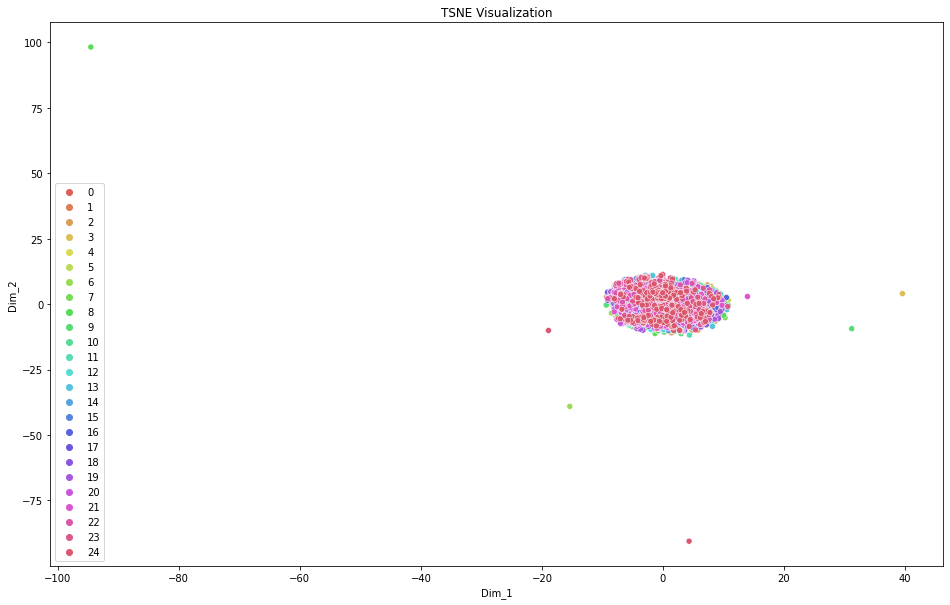

In [ ]:
data=datasets.ImageFolder(root=r'/content/drive/MyDrive/Project/Dataset/freiburg_dataset')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 25),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()

In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

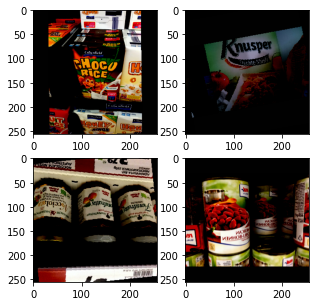

In [ ]:
plot_data_loader(train_loader,(2,2))

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [5]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model,accuracy1,loss1, val_acc1, val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 3.1314, Accuracy: 14.10%, Validation Loss : 3.0703, Validation Accuracy : 15.69%,
Epoch [2/50], Loss: 3.0693, Accuracy: 11.73%, Validation Loss : 2.9323, Validation Accuracy : 17.03%,
Epoch [3/50], Loss: 2.8597, Accuracy: 16.32%, Validation Loss : 2.7393, Validation Accuracy : 19.32%,
Epoch [4/50], Loss: 2.7114, Accuracy: 20.56%, Validation Loss : 2.7516, Validation Accuracy : 19.67%,
Epoch [5/50], Loss: 2.5893, Accuracy: 23.00%, Validation Loss : 2.6076, Validation Accuracy : 23.43%,
Epoch [6/50], Loss: 2.5167, Accuracy: 24.41%, Validation Loss : 2.6511, Validation Accuracy : 22.91%,
Epoch [7/50], Loss: 2.4452, Accuracy: 26.95%, Validation Loss : 2.5094, Validation Accuracy : 23.91%,
Epoch [8/50], Loss: 2.3518, Accuracy: 29.03%, Validation Loss : 2.4144, Validation Accuracy : 27.89%,
Epoch [9/50], Loss: 2.2730, Accuracy: 30.11%, Validation Loss : 2.3673, Validation Accuracy : 28.32%,
Epoch [10/50], Loss: 2.1988, Accuracy: 33.25%, Validation Loss : 2.

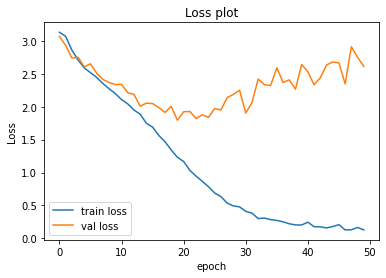

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()


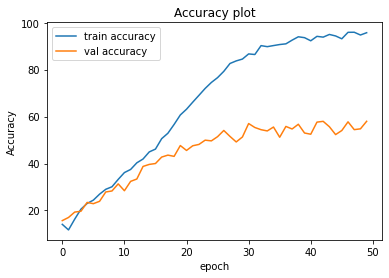

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()


In [ ]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 815 test images: 42.82208588957055 %


In [ ]:
#Saving model
torch.save(model, 'model_resnet1.pt')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_true = []
y_pred = []
 
for data in test_loader:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('SUGAR', 'TOMATO_SAUCE', 'SPICES', 'WATER',
           'VINEGAR', 'TEA', 'RICE', 'PASTA', 'OIL', 'SODA','CORN','HONEY','FLOUR','JUICE','MILK','NUTS','COFFEE','JAM','CHOCOLATE','FISH','CANDY','CHIPS','BEANS','CAKE','CEREAL')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

Transfer Learning for Freiburg dataset with resnet18 architecture

In [6]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',pretrained=True)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
model,accuracy1,loss1, val_acc1, val_loss1=train( model, train_loader,val_loader, criterion, optimizer,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 2.7499, Accuracy: 26.03%, Validation Loss : 2.4293, Validation Accuracy : 31.87%,
Epoch [2/50], Loss: 3.3494, Accuracy: 6.72%, Validation Loss : 3.2508, Validation Accuracy : 5.34%,
Epoch [3/50], Loss: 3.2136, Accuracy: 6.34%, Validation Loss : 3.1972, Validation Accuracy : 5.54%,
Epoch [4/50], Loss: 3.1624, Accuracy: 7.65%, Validation Loss : 3.1155, Validation Accuracy : 10.18%,
Epoch [5/50], Loss: 3.0875, Accuracy: 9.91%, Validation Loss : 3.0638, Validation Accuracy : 8.27%,
Epoch [6/50], Loss: 3.0056, Accuracy: 11.72%, Validation Loss : 2.9885, Validation Accuracy : 12.62%,
Epoch [7/50], Loss: 2.9304, Accuracy: 13.03%, Validation Loss : 2.8709, Validation Accuracy : 14.89%,
Epoch [8/50], Loss: 2.8493, Accuracy: 16.19%, Validation Loss : 2.8665, Validation Accuracy : 17.66%,
Epoch [9/50], Loss: 2.8262, Accuracy: 16.56%, Validation Loss : 2.7936, Validation Accuracy : 17.26%,
Epoch [10/50], Loss: 2.7883, Accuracy: 17.29%, Validation Loss : 2.8200, V

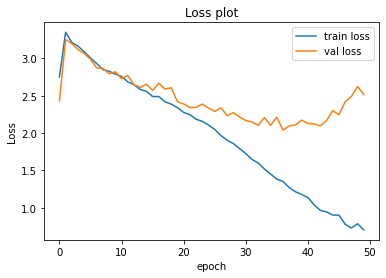

In [8]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
epochs = [i for i in range(num_epochs)]

plt.plot(loss1,label='train loss')
plt.plot(val_loss1,label='val loss')
    
plt.legend()

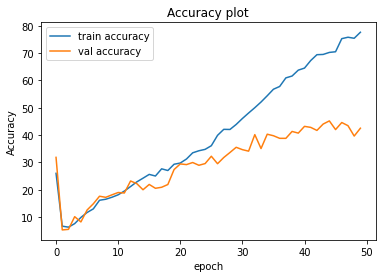

In [9]:
import matplotlib.pyplot as plt

num_epochs= 50
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy1,label='train accuracy')
plt.plot(val_acc1,label='val accuracy')    
plt.legend()

In [10]:
model.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 989 test images: 42.568250758341755 %


In [22]:
torch.save(model, 'model_resnet1_transfer.pt')

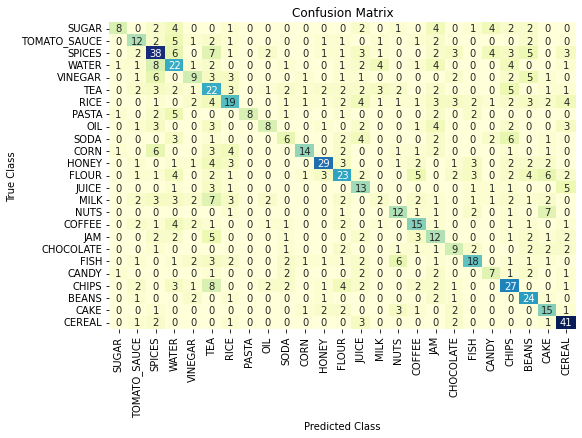

In [13]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
 
for data in test_loader:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('SUGAR', 'TOMATO_SAUCE', 'SPICES', 'WATER',
           'VINEGAR', 'TEA', 'RICE', 'PASTA', 'OIL', 'SODA','CORN','HONEY','FLOUR','JUICE','MILK','NUTS','COFFEE','JAM','CHOCOLATE','FISH','CANDY','CHIPS','BEANS','CAKE','CEREAL')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [14]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       SUGAR       0.67      0.26      0.37        31
TOMATO_SAUCE       0.40      0.39      0.39        31
      SPICES       0.46      0.46      0.46        82
       WATER       0.33      0.42      0.37        53
     VINEGAR       0.38      0.26      0.31        35
         TEA       0.27      0.39      0.32        57
        RICE       0.42      0.33      0.37        58
       PASTA       1.00      0.36      0.53        22
         OIL       0.50      0.29      0.36        28
        SODA       0.30      0.22      0.26        27
        CORN       0.70      0.39      0.50        36
       HONEY       0.67      0.53      0.59        55
       FLOUR       0.43      0.37      0.40        62
       JUICE       0.28      0.50      0.36        26
        MILK       0.15      0.06      0.08        36
        NUTS       0.43      0.46      0.44        26
      COFFEE       0.41      0.44      0.42        34
         JAM       0.24    

Resnet-18 for Grocery dataset

In [15]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torch.optim as optim

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def load_data_grocery_store(path, batch_size, input_size):
    
    transform_dict={'src':transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomRotation(5),transforms.RandomHorizontalFlip(), transforms.Resize(256),
                                              transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])}
    data1 = datasets.ImageFolder(root=path,transform=transform_dict['src'])
    data_loader=td.DataLoader(data1,batch_size,shuffle=True,drop_last=False,num_workers=0)  
    return data_loader

train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=32, input_size=[224,224])
test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=32, input_size=[224,224])
val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=32, input_size=[224,224])

TSNE Visualization

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2427 samples in 0.021s...
[t-SNE] Computed neighbors for 2427 samples in 3.074s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2427
[t-SNE] Computed conditional probabilities for sample 2000 / 2427
[t-SNE] Computed conditional probabilities for sample 2427 / 2427
[t-SNE] Mean sigma: 1730.898544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.997978
[t-SNE] KL divergence after 300 iterations: 2.278957


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_core.py:882: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  val in data


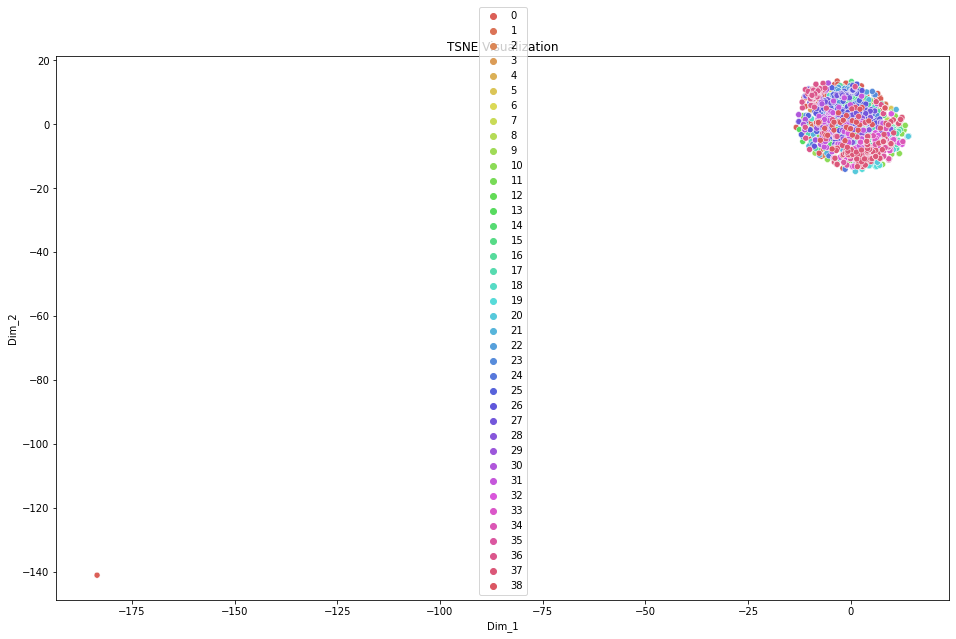

In [ ]:
data=datasets.ImageFolder(root=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train')
random=0
X=[]
Y=[]
for x,y in data:
                          xrs=x.resize((64,64))
                          img=np.array(xrs).reshape(64*64*3)
                          X.append(img)
                          Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(tsne[:,0],tsne[:,1],hue=Y,palette=sns.color_palette("hls", 39),data=data,legend="full")
# Using Plt.scatter, visualize the transformed data marked with their corresponding label in 2D embedding.
plt.title('TSNE Visualization')
plt.xlabel('Dim_1')
plt.ylabel('Dim_2')
plt.show()
plt.close()

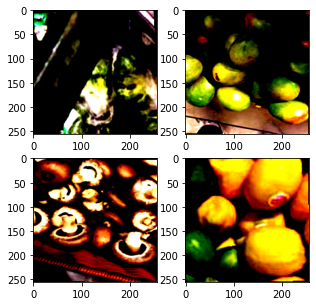

In [ ]:
plot_data_loader(train_loader2,(2,2))

In [ ]:
model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
optimizer2 = torch.optim.Adam(model2.parameters())
criterion2 = nn.CrossEntropyLoss()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
def train( model, train_loader,val_loader, criterion, optimizer,num_epochs):
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("Device: {}".format(device))
      model.to(device)
      total_steps = len(train_loader)
      t1 = time.time()
      accuracy1 = []
      loss1 = []
      val_acc=[]
      val_loss=[]
      for epoch in range(num_epochs):
          accu = 0
          lss = 0
          val_accu=0
          valid_loss=0
          for i,data in enumerate(train_loader):
              images, labels = data[0].to(device), data[1].to(device)
              # Forward pass
              outputs = model(images)
              loss = criterion(outputs, labels)
              # Backprop and optimisation
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              # Train accuracy
              total = labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == labels).sum().item()
              accu += (correct / total) * 100
              lss += loss.item()
          model.eval()  
          for i, data in enumerate(val_loader):
              val_images, val_labels = data[0].to(device), data[1].to(device)
              outputs = model(val_images)
              loss = criterion(outputs, val_labels)
              # Val accuracy
              total = val_labels.size(0)
              _,predicted = torch.max(outputs.data, 1)
              correct = (predicted == val_labels).sum().item()
              val_accu += (correct / total) * 100
              valid_loss += loss.item()
          val_acc.append(val_accu/len(val_loader))
          val_loss.append(valid_loss/len(val_loader))
          accuracy1.append(accu/len(train_loader))
          loss1.append(lss/len(train_loader))
          
          print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%, Validation Loss : {:.4f}, Validation Accuracy : {:.2f}%,'.format(epoch + 1, num_epochs,lss/len(train_loader) ,accu/len(train_loader), valid_loss/len(val_loader), val_accu/len(val_loader)))
      print("######## Training Finished in {} seconds ###########".format(time.time()-t1))
      return model, accuracy1, loss1,val_acc,val_loss

In [ ]:
model2,accuracy2,loss2,val_acc2,val_loss2=train(model2, train_loader2,val_loader2, criterion2, optimizer2,num_epochs=50)

Device: cuda:0
Epoch [1/50], Loss: 2.8079, Accuracy: 23.88%, Validation Loss : 3.1494, Validation Accuracy : 15.33%,
Epoch [2/50], Loss: 2.3780, Accuracy: 28.40%, Validation Loss : 2.4753, Validation Accuracy : 20.22%,
Epoch [3/50], Loss: 2.1092, Accuracy: 35.12%, Validation Loss : 2.4756, Validation Accuracy : 23.20%,
Epoch [4/50], Loss: 1.8194, Accuracy: 40.93%, Validation Loss : 2.1157, Validation Accuracy : 32.10%,
Epoch [5/50], Loss: 1.7250, Accuracy: 43.37%, Validation Loss : 2.1588, Validation Accuracy : 27.21%,
Epoch [6/50], Loss: 1.7349, Accuracy: 43.11%, Validation Loss : 2.0587, Validation Accuracy : 34.19%,
Epoch [7/50], Loss: 1.5857, Accuracy: 48.25%, Validation Loss : 2.0431, Validation Accuracy : 31.80%,
Epoch [8/50], Loss: 1.5031, Accuracy: 50.29%, Validation Loss : 2.0520, Validation Accuracy : 35.32%,
Epoch [9/50], Loss: 1.3840, Accuracy: 54.03%, Validation Loss : 1.9542, Validation Accuracy : 39.80%,
Epoch [10/50], Loss: 1.2868, Accuracy: 56.66%, Validation Loss : 1.

In [ ]:
torch.save(model2, 'model_resnet2.pt')

[2.8078891509457637, 2.377973258495331, 2.1092103798138466, 1.8193642214724892, 1.7249987988095534, 1.7348645549071462, 1.585733573687704, 1.5031324554430812, 1.3839653871561353, 1.2867540975934582, 1.2562576265711534, 1.2091525455838756, 1.0790338045672367, 1.019522996325242, 1.0441675782203674, 0.9488655697358283, 0.9817532587208246, 0.8899346092029622, 0.9053160038433576, 0.7625961688004042, 0.7291909013139574, 0.7144589804505047, 0.7230135849431941, 0.6863958431701911, 0.6436896673158595, 0.6659014970064163, 0.5705026262684872, 0.5707494193001798, 0.5781549785874391, 0.5519210649164099, 0.4787911855076489, 0.5077978474529166, 0.5283680936615718, 0.46434384094257103, 0.4215195304469058, 0.422553164982482, 0.38526951874557297, 0.4602611078635642, 0.3977261016047315, 0.40395595074484225, 0.43453540260854523, 0.3986960900457282, 0.36487220972776413, 0.320790482488902, 0.33111839447366564, 0.35973358615056467, 0.36098869458625193, 0.3174635418935826, 0.40127798120834324, 0.2755027363861

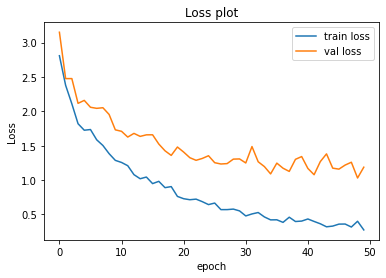

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 30
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(loss2,label='train loss')
plt.plot(val_loss2,label='val loss')
    
plt.legend()

print(loss2)

[23.87609649122807, 28.399122807017545, 35.12426900584795, 40.93262670565302, 43.370796783625735, 43.108857212475634, 48.24865984405458, 50.28630604288499, 54.03112816764133, 56.65661549707602, 58.79020467836258, 60.20346003898635, 64.09143518518518, 65.13767056530214, 66.22959307992203, 68.72258771929825, 66.7230141325536, 70.2333089668616, 71.17141812865496, 75.40204678362574, 76.59143518518518, 76.24269005847952, 76.72240497076022, 76.52442738791423, 78.83467348927876, 78.37780214424951, 82.18354044834308, 80.37432992202729, 81.99317738791423, 82.36324317738791, 84.35977095516569, 83.73842592592592, 83.30896686159845, 85.75018274853801, 86.39284844054582, 86.54666179337232, 87.74975633528265, 85.44712475633528, 87.97819200779726, 87.07358674463937, 86.14613791423002, 87.3614156920078, 88.38937621832358, 90.14985380116958, 89.68232212475634, 88.80817495126706, 88.55384990253411, 90.05238791423002, 87.72386695906432, 91.64534600389864]


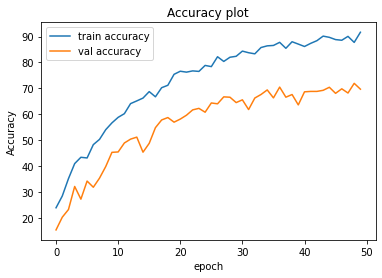

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 30
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(accuracy2,label='train accuracy')
plt.plot(val_acc2, label='val accuracy')
    
plt.legend()

print(accuracy2)

In [ ]:
model2.eval() 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = model2.to(device)
with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader2:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'
        .format(total, (correct / total) * 100))

Test Accuracy of the model on the 2423 test images: 75.81510524143623 %


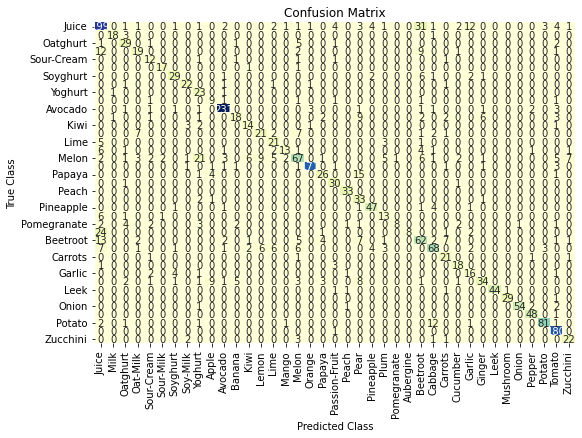

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
y_true = []
y_pred = []
 
for data in test_loader2:
  images,labels=data[0].to(device),data[1]
  y_true.extend(labels.numpy())
  outputs=model2(images)
  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('Juice', 'Milk', 'Oatghurt', 'Oat-Milk',
           'Sour-Cream', 'Sour-Milk', 'Soyghurt', 'Soy-Milk', 'Yoghurt', 'Apple','Avocado','Banana','Kiwi','Lemon','Lime','Mango','Melon','Orange','Papaya',
           'Passion-Fruit','Peach','Pear','Pineapple','Plum','Pomegranate','Aubergine',
           'Beetroot','Cabbage','Carrots','Cucumber','Garlic','Ginger','Leek','Mushroom','Onion','Pepper','Potato','Tomato','Zucchini')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

In [ ]:
#Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names))

               precision    recall  f1-score   support

        Juice       0.71      0.72      0.72       276
         Milk       0.90      0.82      0.86        22
     Oatghurt       0.63      0.72      0.67        40
     Oat-Milk       0.58      0.43      0.49        44
   Sour-Cream       0.50      0.71      0.59        17
    Sour-Milk       0.85      0.89      0.87        19
     Soyghurt       0.76      0.69      0.72        42
     Soy-Milk       0.76      0.81      0.79        27
      Yoghurt       0.38      0.92      0.54        25
        Apple       0.38      0.60      0.46        15
      Avocado       0.94      0.94      0.94       247
       Banana       0.64      0.40      0.49        45
         Kiwi       0.58      0.67      0.62        21
        Lemon       0.58      0.51      0.55        41
         Lime       0.54      0.70      0.61        30
        Mango       0.76      0.42      0.54        31
        Melon       0.64      0.44      0.52       153
       Or

Hyperparameter tuning for Resnet18 model with Grocery Store dataset using Grid Search on Learning Rates 0.01,0.001,0.0001

In [19]:
hyper_parameters={"learning_rate":[0.01,0.001,0.0001]}
l=["lr0.01","lr0.001","lr0.0001"]
train_loss_hyper_parameters = {}
train_acc_hyper_parameters={}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for learning_rate in hyper_parameters["learning_rate"]:
    print(f'Results of the learning rate = {learning_rate}')
nested_list=list(hyper_parameters.values())
list_hyper=nested_list[0]
for i in range(0,len(list_hyper)):
  model_hyper=model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
  model_hyper.to(device)
  optimizer_hyper= torch.optim.Adam(model_hyper.parameters(), lr=list_hyper[i])
  criterion_hyper=nn.CrossEntropyLoss()
  train_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Train', batch_size=32, input_size=[224,224])
  test_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Test', batch_size=32, input_size=[224,224])
  val_loader2=load_data_grocery_store(path=r'/content/drive/MyDrive/Project/Dataset/Grocery_store_dataset/Val', batch_size=32, input_size=[224,224])
  print('Training with Learning Rate {}'.format(list_hyper[i]))
  model_hyper,train_loss_hyper,train_accuracy_hyper,val_acc,val_loss = train(model_hyper,train_loader2,val_loader2,criterion_hyper,optimizer_hyper,50)
  train_loss_hyper_parameters[l[i]]=train_loss_hyper
  train_acc_hyper_parameters[l[i]]=train_accuracy_hyper

Results of the learning rate = 0.01
Results of the learning rate = 0.001
Results of the learning rate = 0.0001


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Training with Learning Rate 0.01
Device: cuda:0
Epoch [1/50], Loss: 3.5380, Accuracy: 12.67%, Validation Loss : 3.2880, Validation Accuracy : 8.63%,
Epoch [2/50], Loss: 2.9129, Accuracy: 17.00%, Validation Loss : 3.0341, Validation Accuracy : 12.93%,
Epoch [3/50], Loss: 2.5892, Accuracy: 22.42%, Validation Loss : 2.7725, Validation Accuracy : 13.99%,
Epoch [4/50], Loss: 2.3581, Accuracy: 27.49%, Validation Loss : 2.4706, Validation Accuracy : 25.12%,
Epoch [5/50], Loss: 2.0516, Accuracy: 33.60%, Validation Loss : 2.6137, Validation Accuracy : 19.91%,
Epoch [6/50], Loss: 1.9281, Accuracy: 38.30%, Validation Loss : 2.2969, Validation Accuracy : 30.47%,
Epoch [7/50], Loss: 1.8242, Accuracy: 42.32%, Validation Loss : 2.1248, Validation Accuracy : 31.05%,
Epoch [8/50], Loss: 1.6454, Accuracy: 46.59%, Validation Loss : 1.9460, Validation Accuracy : 39.95%,
Epoch [9/50], Loss: 1.5483, Accuracy: 49.73%, Validation Loss : 1.8996, Validation Accuracy : 40.26%,
Epoch [10/50], Loss: 1.4824, Accura

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

num_epochs= 50
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_loss_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()

In [ ]:
num_epochs= 50
epochs = [i for i in range(num_epochs)]
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

for learning_rate in hyper_parameters["learning_rate"]:
    plt.plot(epochs,train_acc_hyper_parameters[f'lr{learning_rate}'],label=f'learning rate: {learning_rate}')
    
plt.legend()